## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [30]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Fri Mar 29 21:13:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 419.35       Driver Version: 419.35       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8    N/A /  N/A |    885MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [31]:
import os
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from numba import cuda
plt.style.use('seaborn')
import itertools
# Disable GPU

In [2]:
# release memory
cuda.select_device(0)
cuda.close()

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
keras.backend.clear_session()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
def build_mlp(input_shape=x_train.shape[1:], output_units=y_train.shape[-1], num_neurons=[512, 256, 128]):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layers'+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layers'+str(i+1))(x)
            
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 512
MOMENTUM = [0.7, 0.8, 0.9, 0.95, 1.0]
NESTEROV = [False, True]

In [9]:
def model_fitting(LR, EP, BS, MOMT, NTRV, input_shape=x_train.shape[1:], NN=[512, 256, 128]):
    
    keras.backend.clear_session()

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    
    model = build_mlp(input_shape=input_shape)
    model.summary()
    
    optimizer = keras.optimizers.SGD(lr=LR, nesterov=NTRV, momentum=MOMT)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    history = model.fit(x_train, y_train, 
                        epochs=EP, 
                        batch_size=BS, 
                        validation_data=(x_test, y_test), 
                        shuffle=False)
    
    sess.close()

    return history

In [10]:
results = {}

for (momt, ntrv) in list(itertools.product(MOMENTUM, NESTEROV)):
    
    history = model_fitting(LR=LEARNING_RATE,
                            EP=EPOCHS,
                            BS=BATCH_SIZE,
                            MOMT=momt,
                            NTRV=ntrv)
    
    # collect results
    name_tag = f"MM-{momt}, NTRV-{ntrv}"
    results[name_tag] = {'train_loss': history.history['loss'],
                         'valid_loss': history.history['val_loss'],
                         'train_acc': history.history['acc'],
                         'valid_acc': history.history['val_acc']}


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 95us/step - loss: 2.2

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 69us/step - loss: 2.2402 - acc: 0.1638 - val_loss: 2.1671 - val_acc: 0.2125
Epoch 2/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.1223 - acc: 0.2369 - val_loss: 2.0806 - val_acc: 0.2546
Epoch 3/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.0515 - acc: 0.2703 - val_loss: 2.0220 - val_acc: 0.2815
Epoch 4/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.0002 - acc: 0.2948 - val_loss: 1.9775 - val_acc: 0.3040
Epoch 5/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.9612 - acc: 0.3122 - val_loss: 1.9444 - val_acc: 0.3177
Epoch 6/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.9315 - acc: 0.3247 - val_loss: 1.9185 - val_acc: 0.3258
Epoch 7/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.9076 - acc: 0.3350 - val_loss: 1.8975 - val_acc

50000/50000 [==============================] - 3s 62us/step - loss: 2.0967 - acc: 0.2705 - val_loss: 2.0420 - val_acc: 0.2871
Epoch 3/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.0057 - acc: 0.3055 - val_loss: 1.9708 - val_acc: 0.3093
Epoch 4/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.9457 - acc: 0.3235 - val_loss: 1.9231 - val_acc: 0.3216
Epoch 5/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.9036 - acc: 0.3349 - val_loss: 1.8881 - val_acc: 0.3347
Epoch 6/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.8724 - acc: 0.3447 - val_loss: 1.8616 - val_acc: 0.3460
Epoch 7/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.8480 - acc: 0.3535 - val_loss: 1.8401 - val_acc: 0.3543
Epoch 8/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.8278 - acc: 0.3597 - val_loss: 1.8218 - val_acc: 0.3609
Epoch 9/50
50000/50000 [============================

Epoch 4/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.9517 - acc: 0.3191 - val_loss: 1.9263 - val_acc: 0.3225
Epoch 5/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.9101 - acc: 0.3329 - val_loss: 1.8921 - val_acc: 0.3332
Epoch 6/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.8785 - acc: 0.3432 - val_loss: 1.8650 - val_acc: 0.3433
Epoch 7/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.8534 - acc: 0.3525 - val_loss: 1.8432 - val_acc: 0.3503
Epoch 8/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.8330 - acc: 0.3598 - val_loss: 1.8249 - val_acc: 0.3577
Epoch 9/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.8154 - acc: 0.3657 - val_loss: 1.8087 - val_acc: 0.3640
Epoch 10/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.7999 - acc: 0.3718 - val_loss: 1.7944 - val_acc: 0.3701
Epoch 11/50
50000/50000 [===============

50000/50000 [==============================] - 3s 63us/step - loss: 1.8233 - acc: 0.3658 - val_loss: 1.8108 - val_acc: 0.3643
Epoch 6/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.7943 - acc: 0.3756 - val_loss: 1.7849 - val_acc: 0.3727
Epoch 7/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.7694 - acc: 0.3849 - val_loss: 1.7626 - val_acc: 0.3818
Epoch 8/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.7473 - acc: 0.3927 - val_loss: 1.7426 - val_acc: 0.3858
Epoch 9/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.7275 - acc: 0.3993 - val_loss: 1.7239 - val_acc: 0.3946
Epoch 10/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.7096 - acc: 0.4043 - val_loss: 1.7068 - val_acc: 0.4025
Epoch 11/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.6929 - acc: 0.4105 - val_loss: 1.6906 - val_acc: 0.4085
Epoch 12/50
50000/50000 [=========================

Epoch 7/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.7578 - acc: 0.3855 - val_loss: 1.7522 - val_acc: 0.3823
Epoch 8/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.7344 - acc: 0.3936 - val_loss: 1.7306 - val_acc: 0.3896
Epoch 9/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.7135 - acc: 0.4025 - val_loss: 1.7109 - val_acc: 0.3982
Epoch 10/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6944 - acc: 0.4094 - val_loss: 1.6930 - val_acc: 0.4063
Epoch 11/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.6766 - acc: 0.4163 - val_loss: 1.6771 - val_acc: 0.4107
Epoch 12/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6602 - acc: 0.4219 - val_loss: 1.6622 - val_acc: 0.4160
Epoch 13/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6449 - acc: 0.4268 - val_loss: 1.6485 - val_acc: 0.4214
Epoch 14/50
50000/50000 [============

50000/50000 [==============================] - 3s 62us/step - loss: 1.6512 - acc: 0.4247 - val_loss: 1.6438 - val_acc: 0.4248
Epoch 9/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6277 - acc: 0.4320 - val_loss: 1.6214 - val_acc: 0.4317
Epoch 10/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.6063 - acc: 0.4384 - val_loss: 1.6013 - val_acc: 0.4371
Epoch 11/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.5862 - acc: 0.4459 - val_loss: 1.5828 - val_acc: 0.4425
Epoch 12/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.5675 - acc: 0.4520 - val_loss: 1.5682 - val_acc: 0.4441
Epoch 13/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.5505 - acc: 0.4579 - val_loss: 1.5554 - val_acc: 0.4473
Epoch 14/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.5355 - acc: 0.4629 - val_loss: 1.5449 - val_acc: 0.4504
Epoch 15/50
50000/50000 [======================

Epoch 10/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.5958 - acc: 0.4414 - val_loss: 1.5976 - val_acc: 0.4392
Epoch 11/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.5752 - acc: 0.4482 - val_loss: 1.5803 - val_acc: 0.4445
Epoch 12/50
50000/50000 [==============================] - 3s 70us/step - loss: 1.5559 - acc: 0.4544 - val_loss: 1.5644 - val_acc: 0.4495
Epoch 13/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.5383 - acc: 0.4605 - val_loss: 1.5505 - val_acc: 0.4546
Epoch 14/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.5218 - acc: 0.4678 - val_loss: 1.5373 - val_acc: 0.4580
Epoch 15/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.5060 - acc: 0.4722 - val_loss: 1.5254 - val_acc: 0.4609
Epoch 16/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.4912 - acc: 0.4784 - val_loss: 1.5136 - val_acc: 0.4652
Epoch 17/50
50000/50000 [=========

Epoch 12/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.6331 - acc: 0.4226 - val_loss: 1.6285 - val_acc: 0.4238
Epoch 13/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.6275 - acc: 0.4238 - val_loss: 1.6301 - val_acc: 0.4250
Epoch 14/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.6140 - acc: 0.4280 - val_loss: 1.6363 - val_acc: 0.4223
Epoch 15/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.6212 - acc: 0.4296 - val_loss: 1.6553 - val_acc: 0.4204
Epoch 16/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.6186 - acc: 0.4281 - val_loss: 1.6313 - val_acc: 0.4229
Epoch 17/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.6090 - acc: 0.4307 - val_loss: 1.6192 - val_acc: 0.4302
Epoch 18/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.6046 - acc: 0.4323 - val_loss: 1.6073 - val_acc: 0.4232
Epoch 19/50
50000/50000 [=========

50000/50000 [==============================] - 3s 61us/step - loss: 1.4860 - acc: 0.4786 - val_loss: 1.5258 - val_acc: 0.4621
Epoch 14/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.4847 - acc: 0.4752 - val_loss: 1.5279 - val_acc: 0.4590
Epoch 15/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.4709 - acc: 0.4810 - val_loss: 1.5159 - val_acc: 0.4635
Epoch 16/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.4628 - acc: 0.4875 - val_loss: 1.5145 - val_acc: 0.4696
Epoch 17/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.4530 - acc: 0.4885 - val_loss: 1.5220 - val_acc: 0.4653
Epoch 18/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.4491 - acc: 0.4856 - val_loss: 1.5119 - val_acc: 0.4741
Epoch 19/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.4413 - acc: 0.4915 - val_loss: 1.5209 - val_acc: 0.4743
Epoch 20/50
50000/50000 [=====================

In [39]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

def plotting(results, color_bar=colors):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    
    for i, cond in enumerate(results.keys()):

        epochs = range(1, len(results[cond]['train_loss']) + 1)

        ax1.plot(epochs, results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
        ax1.plot(epochs, results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
        
        ax2.plot(epochs, results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
        ax2.plot(epochs, results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
        
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_title('Loss', fontsize=25)
    ax1.legend()
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_title('Accuracy', fontsize=25)
    ax2.legend()
    plt.show()

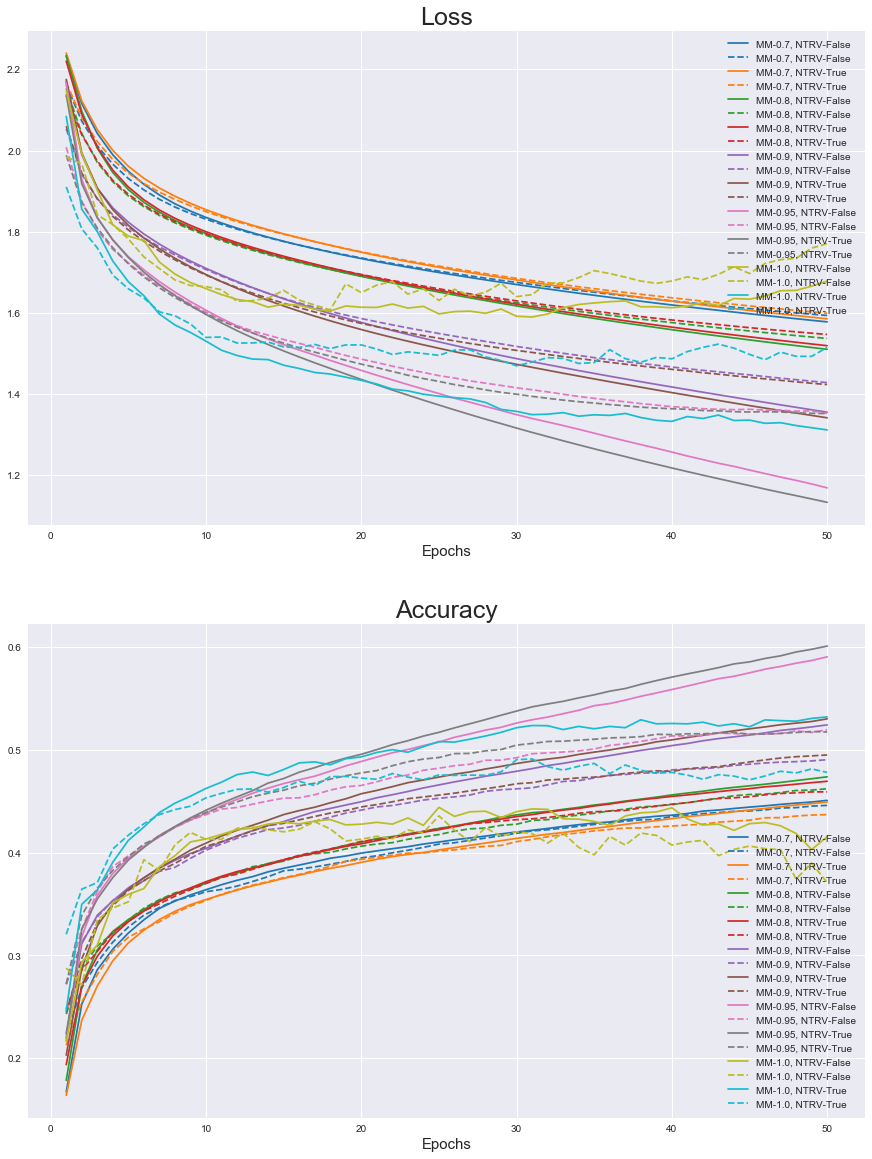

In [40]:
plotting(results)